In [1]:
# Needed imports
import queueing_tool as qt
import networkx as nx
import numpy as np

# Ad-hoc files.
from by_order_queue_server import ByOrderQueueServer
from initializable_queue_server import InitializableQueueServer
from priority_seize_agent import PrioritySeizeAgent

# Problem description
We have a surgical area where patients go first through a surgical room to pass later into a recovery bed. Most of intervantions have been programmed in advance. Some of them are performed on ambulatory patients (the shorter ones) and other on inpatients (the longer ones). From time to time an urgent patient can appear without any previous programmation.

## Assumptions
1. All surgical rooms are the same. That means any patient can be operated in any room.
2. All URPA beds are the same. That means any patient can recovery in any bed.
3. All the interventions are programmed in advance, but the urgent ones, which come following a Poisson distribution.
4. The urgent interventions are prioritary, hence if a surgical room is empty, an urgent patient will always take that room.
5. Once the surgery has finished, there are no more urgent patients. That means the queue before URPA is FIFO.

## Initial Diagram

<img src=" 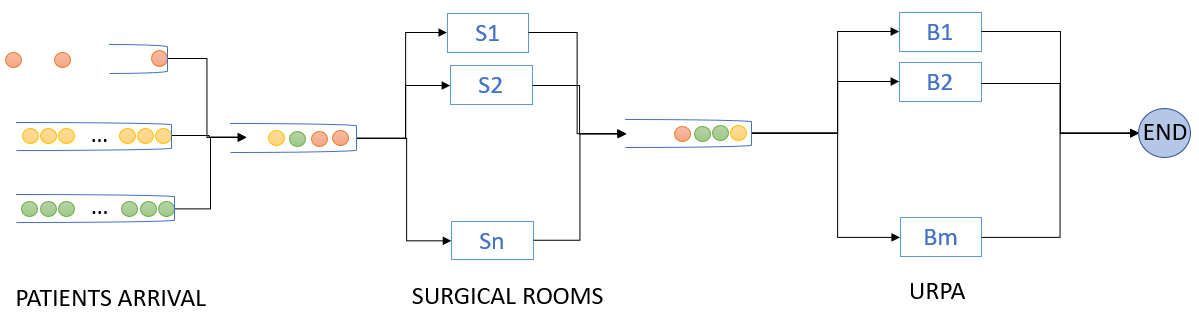" />

6. We will consider: 1 minute = 1 time step. 
7. We will simulate: 1 day of surgery.

In [2]:
HOUR = 60
SIMULATING_TIME = 24*HOUR

8. There are 3 surgical rooms
9. There are 10 URPA beds.

In [3]:

AMOUNT_OF_SURGICAL_ROOMS = 3
AMOUNT_OF_URPA_BEDS = 10

Today's situation:

10. 10 inpatients programmed to go through a surgery
11. 20 ambulatory patients programmed to go through a surgery

In [4]:
inpatients_programmed = 10
ambulatory_programmed = 20

We design the nodes and the edges of our network.

In [5]:
# Defining nodes
emergency_patients_waiting_room = 0
programmed_patients_waiting_room = 1
ambulatory_patients_waiting_room = 2
surgical_waiting_room = 3
urpa_waiting_room = 4
exit = 5

# Creating the graph.
adja_list = {emergency_patients_waiting_room: [surgical_waiting_room],
             programmed_patients_waiting_room: [surgical_waiting_room],
             ambulatory_patients_waiting_room: [surgical_waiting_room],
             surgical_waiting_room: [urpa_waiting_room],
             urpa_waiting_room: [exit]}

TYPE_EMERGENCY_INCOMING_QUEUE = 1
TYPE_INPATIENT_PROGRAMMED_QUEUE = 2
TYPE_AMBULATORY_PROGRAMMED_QUEUE = 3
TYPE_SURGICAL_ROOM_QUEUE = 4
TYPE_URPA_QUEUE = 5
edge_list = {emergency_patients_waiting_room: {surgical_waiting_room: TYPE_EMERGENCY_INCOMING_QUEUE},
             programmed_patients_waiting_room: {surgical_waiting_room: TYPE_INPATIENT_PROGRAMMED_QUEUE},
             ambulatory_patients_waiting_room: {surgical_waiting_room: TYPE_AMBULATORY_PROGRAMMED_QUEUE},
             surgical_waiting_room: {urpa_waiting_room: TYPE_SURGICAL_ROOM_QUEUE},
             urpa_waiting_room: {exit: TYPE_URPA_QUEUE}}

g = qt.adjacency2graph(adjacency=adja_list, edge_type=edge_list)

Once we have the queues, we set how will behave the patients and the server that will attend them. To make the approach easiest, we will consider arrival times and serving times to be  a fixed value all the arrival times at any queue:

* The emergency patients will arrive at a fixed rate: 1 patient / hour.
* The server in the three initial queues will send them to the surgical room with out any delay.
* The surgical room serves the patient at a fixed rate: 1 patient / 0.5 hour.
* A patient usually needs 2 hours in a URPA bed before being discharged.

In [6]:

def initializing_operating_rooms(t):
    #we send the next event out of the simulation time.
    return t+SIMULATING_TIME+1

# Creating the network.
q_classes = {TYPE_EMERGENCY_INCOMING_QUEUE: qt.QueueServer,
             TYPE_INPATIENT_PROGRAMMED_QUEUE: ByOrderQueueServer,
             TYPE_AMBULATORY_PROGRAMMED_QUEUE: ByOrderQueueServer,
             TYPE_SURGICAL_ROOM_QUEUE: ByOrderQueueServer,
             TYPE_URPA_QUEUE: qt.QueueServer}

q_args = {
    TYPE_EMERGENCY_INCOMING_QUEUE: {
        'arrival_f': lambda t: t+HOUR,
        'service_f': lambda t: t,
        'AgentFactory': PrioritySeizeAgent,
    },
    TYPE_INPATIENT_PROGRAMMED_QUEUE: {
        'arrival_f': initializing_operating_rooms,
        'service_f': lambda t: t,
        'AgentFactory': PrioritySeizeAgent,
        'initial_queue': inpatients_programmed,
    },
    TYPE_AMBULATORY_PROGRAMMED_QUEUE: {
        'arrival_f': initializing_operating_rooms,
        'service_f': lambda t: t,
        'AgentFactory': PrioritySeizeAgent,
        'initial_queue': ambulatory_programmed,
    },
    TYPE_SURGICAL_ROOM_QUEUE: {
        'num_servers': AMOUNT_OF_SURGICAL_ROOMS,
        'service_f': lambda t: t + HOUR/2
    },
    TYPE_URPA_QUEUE: {
        'num_servers': AMOUNT_OF_URPA_BEDS,
        'service_f': lambda t: t + 2 * HOUR
    }
}

qn = qt.QueueNetwork(g=g, q_classes=q_classes, q_args=q_args, seed=13)


# Initializing which nodes receives agents
qn.initialize(edge_type=[TYPE_EMERGENCY_INCOMING_QUEUE, TYPE_INPATIENT_PROGRAMMED_QUEUE, TYPE_AMBULATORY_PROGRAMMED_QUEUE])

# Command the queue start to collect data.
qn.start_collecting_data()

We run the simulation

In [7]:
qn.simulate(t=SIMULATING_TIME)
print("Number of events:" + str(qn.num_events))

Number of events:211


We save the data each queue produced as well as the data each agent produced.

In [8]:
# We save the queue data. It's stored with the following columns: 
# arrival_time, enter_service_time, departure_time, length of queue, number_of_agents, edge_index_of_queue.
queue_data = qn.get_queue_data() 
np.savetxt("queue_data.csv", queue_data,
           delimiter=",", fmt='%i')
# print(queue_data[0:2])


# Get the data from the agents.
agents_data = qn.get_agent_data()
with open("agent_data.txt", "w") as f:
    for agent in agents_data.keys():
        f.write("\n\nAGENT: " + str(agent)+"\n")
        f.write(np.array2string(
            a=agents_data[agent], formatter={'float_kind': lambda x: "%.0f" % x}))
# print(agents_data[(0, 22)])

We plot an screenshot of the simulation and we produce an animation of the day too

MovieWriter mencoder unavailable; using Pillow instead.


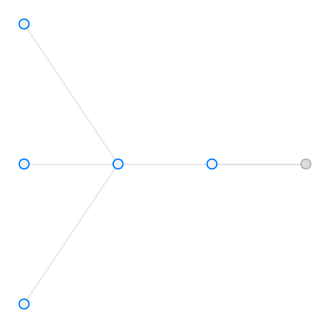

In [9]:
qn.g.new_vertex_property('pos')

pos = {}

for v in qn.g.nodes():
    if v == programmed_patients_waiting_room:
        pos[v] = [0.8, 0]
    if v == ambulatory_patients_waiting_room:
        pos[v] = [0.8, 0.8]
    if v == emergency_patients_waiting_room:
        pos[v] = [0.8, 1.6]
    if v == surgical_waiting_room:
        pos[v] = [1.6, 0.8]
    if v == urpa_waiting_room:
        pos[v] = [2.4, 0.8]
    if v == exit:
        pos[v] = [3.2, 0.8]

qn.g.set_pos(pos)

# Plot an animate.
#qn.draw(fname="sim.png", figsize=(12, 3), bbox_inches='tight',
#       font_size=12, font_color="whitesmoke")

kwargs = {
    'filename': 'animation.gif',
    'frames': qn.num_events*10,
    'fps': 10,
    'writer': 'mencoder',
    'figsize': (4, 4),
    'vertex_size': 15
}
qn.animate(**kwargs) 

We render the animation

![Animation](animation2.gif "Title")